In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns

In [2]:
df_proyectos = pd.read_csv('../analisis/Proyectos_final.csv')

#Drop Title, ArticleURL columns
df_proyectos.drop(['Title', 'ArticleURL'], axis=1, inplace=True)
df_proyectos.drop_duplicates(subset=['Proyecto'], inplace=True)
df_proyectos.head()

,Year,Proyecto,País,Lengua,glottocode,isocode,Cine/TV,Redes sociales,Iniciativa estatal,Organización externa,...,Tecnología,Radio,Documentación,Elaboración de materiales educativos - libros,Fomenta el uso de la lengua,Enseña la lengua,"Público objetivo (niños, jóvenes, adultos, todos)","Proyecto alternativos: nidos, cursos de lengua, otros",Familia,Hablantes
0,2011,Auto-documentación lingüística Jodï,Venezuela,Hoti,yuwa1244,yau,0,0,0,0,...,0,0,1,1,0,0,Todos,-,-,1500
1,2013,Rama Language Project,Nicaragua,Rama,rama1270,rma,0,0,0,0,...,0,0,1,1,1,0,Todos,-,Chibchan,740
2,2023,Aún nuestra lengua vive: fogatas nahuas móvile...,México,Tlaxcala-Puebla-Central Nahuatl,cent2132,nhn,0,0,0,0,...,0,0,0,0,1,1,Todos,Uso de lengua en comunidad,Uto-Aztecan,40000
3,2023,"Inadea (proyectos varios: charlas, cursos de s...",Perú,Huaylay,huay1239,-,0,0,0,0,...,0,0,0,1,0,1,Todos,-,Quechuan,587520
4,2020,Micronoticiero Letras TV Willakun,Perú,Ayacucho Quechua,ayac1239,quy,1,1,0,0,...,1,0,0,0,1,0,Todos,-,Quechuan,1270000


In [3]:
df_proyectos['Digital'] = df_proyectos['Redes sociales'] + df_proyectos['Tecnología']
df_proyectos['Digital'] = df_proyectos['Digital'].apply(lambda x: 1 if x > 0 else 0)

df_proyectos['NonDigital'] = df_proyectos['Digital'].apply(lambda x: 0 if x == 1 else 1)

df_proyectos = df_proyectos[['Year', 'Proyecto', 'Digital', 'NonDigital']]

In [102]:
df_proyectos.head()

,Year,Proyecto,Digital,NonDigital
0,2011,Auto-documentación lingüística Jodï,0,1
1,2013,Rama Language Project,0,1
2,2023,Aún nuestra lengua vive: fogatas nahuas móvile...,0,1
3,2023,"Inadea (proyectos varios: charlas, cursos de s...",0,1
4,2020,Micronoticiero Letras TV Willakun,1,0


In [4]:
total_proyectos = df_proyectos.groupby('Year').size()

num_proyectos_year = df_proyectos.groupby('Year')[['Digital', 'NonDigital']].sum()
num_proyectos_year.to_csv('Num_digital_proyectos_year.csv')

In [5]:
if True:
    i=-2
    df_num_proyectos=num_proyectos_year[:i]

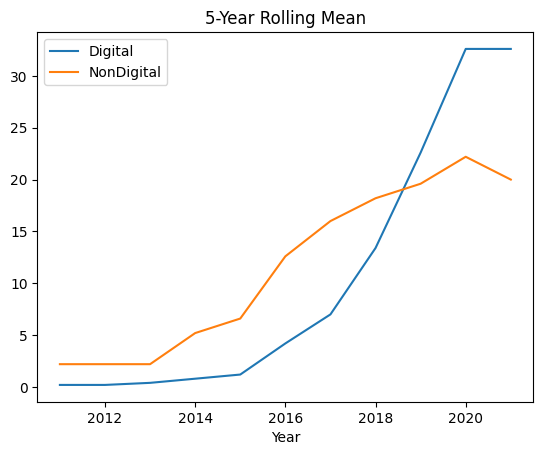

In [6]:
df_mean_5 = df_num_proyectos.rolling(5).mean().dropna()
df_mean_5.plot()
plt.title('5-Year Rolling Mean')
plt.show()

In [7]:
df_mean_expanded = pd.DataFrame(columns=['Year', 'Category', 'Value'])
for year in df_mean_5.index:
    for column in df_mean_5.columns[:3]:
        df_mean_expanded.loc[len(df_mean_expanded)] = [year, column, df_mean_5.loc[year, column]]

# Modelo inicial

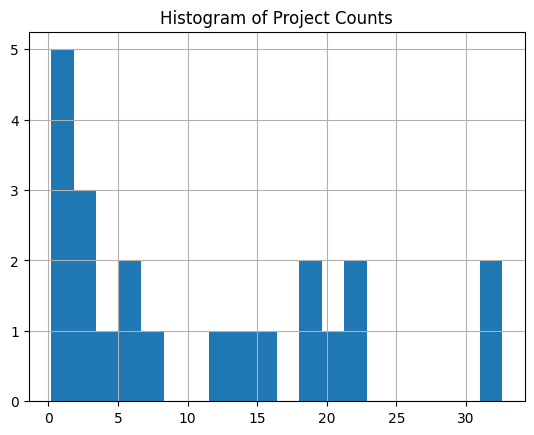

In [8]:
df_mean_expanded['Value'].hist(bins=20)
plt.title('Histogram of Project Counts')
plt.show()

In [9]:
df_num_proyectos_by_year = pd.DataFrame(columns=['Year', 'Value'])
for year in df_num_proyectos.index:
    df_num_proyectos_by_year.loc[len(df_num_proyectos_by_year)] = [year, df_num_proyectos.loc[year].sum()]

In [10]:
#Create exposure variable. Foe each row in df_mean_expanded, the exposure will be the value of df_num_proyectos_by_year for the corresponding year
df_mean_expanded['Exposure'] = 0
for i in range(len(df_mean_expanded)):
    year = df_mean_expanded.loc[i, 'Year']
    df_mean_expanded.loc[i, 'Exposure'] = df_num_proyectos_by_year[df_num_proyectos_by_year['Year'] == year]['Value'].values[0]

In [11]:
poisson_glm = smf.glm('Value ~ Year + Category', data=df_mean_expanded, family=sm.families.Poisson()).fit()
print(poisson_glm.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Value   No. Observations:                   22
Model:                            GLM   Df Residuals:                       19
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -57.687
Date:                Thu, 16 May 2024   Deviance:                       37.442
Time:                        10:18:42   Pearson chi2:                     33.3
No. Iterations:                     5   Pseudo R-squ. (CS):             0.9998
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               -637

In [12]:
#Probamos equidispersion
print('Variance:',df_mean_expanded['Value'].var())
print('Mean:',df_mean_expanded['Value'].mean())
print('Variance/Mean:',df_mean_expanded['Value'].var()/df_mean_expanded['Value'].mean())

Variance: 110.7865800865801
Mean: 11.009090909090908
Variance/Mean: 10.06319059415674


Para tratar la sobredispersión se usará una regresión binomial negativa. Calculamos primero el parámetro alfa a usar

In [14]:
df_mean_expanded['Lambda'] = poisson_glm.mu
df_mean_expanded['AUX_OLS'] = df_mean_expanded.apply(lambda x: ((x['Value'] - x['Lambda'])**2 - x['Lambda']) / x['Lambda'], axis=1)
ols_expr = """AUX_OLS ~ Lambda - 1"""
aux_olsr_results = smf.ols(ols_expr, df_mean_expanded).fit()
print(aux_olsr_results.params)  

Lambda    0.052161
dtype: float64


In [15]:
print(aux_olsr_results.tvalues)
print(poisson_glm.df_resid)

#T-Value (right-tailed): 1.669402
degrees_of_freedom = poisson_glm.df_resid
from scipy.stats import t
alpha = 0.05
t_to_compare=t.ppf(1-alpha, degrees_of_freedom)

if aux_olsr_results.tvalues[0] > t_to_compare:
    print('The alpha parameter is significant')
else:
    print('The alpha parameter is not significant')

alpha = aux_olsr_results.params[0]

Lambda    2.283979
dtype: float64
19
The alpha parameter is significant


# Binomial negativa

In [16]:
alpha=aux_olsr_results.params[0]
nbinomial_glm = smf.glm('Value ~ Year + Category', data=df_mean_expanded, family=sm.families.NegativeBinomial(alpha=alpha)).fit()
print(nbinomial_glm.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Value   No. Observations:                   22
Model:                            GLM   Df Residuals:                       19
Model Family:        NegativeBinomial   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -55.041
Date:                Thu, 16 May 2024   Deviance:                       23.316
Time:                        10:19:02   Pearson chi2:                     19.9
No. Iterations:                     8   Pseudo R-squ. (CS):             0.9970
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               -692

In [18]:
# Calculate Pearson's chi-squared statistic
from scipy import stats


pearson_chi2 = np.sum(nbinomial_glm.resid_pearson**2)

# Calculate degrees of freedom
df = len(nbinomial_glm.resid_pearson) - len(nbinomial_glm.params)

# Calculate dispersion ratio
dispersion_ratio = pearson_chi2 / df

# Calculate p-value
p_value = 1 - stats.chi2.cdf(pearson_chi2, df)

# Print results
print('Overdispersion test\n')
print('dispersion ratio =', dispersion_ratio)
print("Pearson's Chi-Squared =", pearson_chi2)
print('p-value =', p_value)

# Check for overdispersion
if p_value < 0.05:
    print('Model is overdispersed')
else:
    print('Model is not overdispersed')

Overdispersion test

dispersion ratio = 1.0474907468999384
Pearson's Chi-Squared = 19.90232419109883
p-value = 0.4004771520694239
Model is not overdispersed


In [19]:
from sklearn.metrics import mean_squared_error

df_naive_mean = df_mean_5.copy()

for column in df_num_proyectos.columns:
    df_naive_mean[column] = df_naive_mean[column].mean()

    # Get the actual and forecasted values
    actual = df_mean_5[column].values
    naive_mean = df_naive_mean[column].values
    
    # Calculate and print the RMSE
    rmse = sqrt(mean_squared_error(actual, naive_mean))
    print(f'Naive RMSE for {column}: {rmse}')

Naive RMSE for Digital: 12.35218721221549
Naive RMSE for NonDigital: 7.63870094100533


### compara modelos

In [20]:
# Print AIC and BIC for Poisson model
print('Poisson model AIC:', poisson_glm.aic)
print('Poisson model BIC:', poisson_glm.bic)

# Print AIC and BIC for Negative Binomial model
print('Negative Binomial model AIC:', nbinomial_glm.aic)
print('Negative Binomial model BIC:', nbinomial_glm.bic)

Poisson model AIC: 121.37402397745265
Poisson model BIC: -21.287333503372125
Negative Binomial model AIC: 116.08110026212599
Negative Binomial model BIC: -35.413627630902674


c:\Users\amy22\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1838: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.
  warnings.warn(


## Predicciones

In [21]:
df_mean_expanded.reset_index(inplace=True)
df_mean_expanded['Predicted'] = nbinomial_glm.predict(df_mean_expanded)
df_mean_expanded['Residuals'] = df_mean_expanded['Value'] - df_mean_expanded['Predicted']

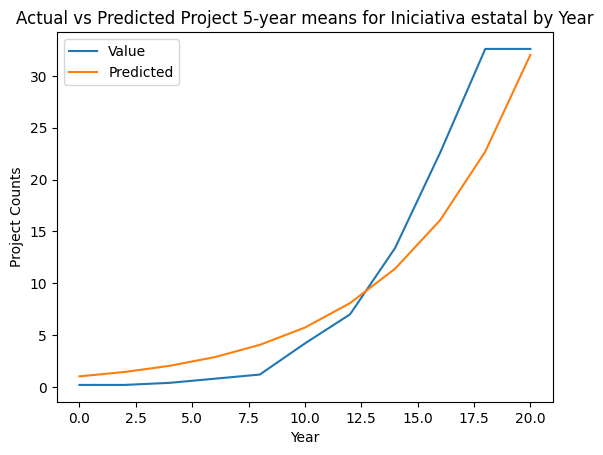

In [119]:
# Set 'Year' as the index
# df_mean_expanded.set_index('Year', inplace=True)

# Plot actual vs predicted project counts
df_mean_expanded[df_mean_expanded['Category']=='Digital'][['Value','Predicted']].plot()
plt.title('Actual vs Predicted Project 5-year means for Iniciativa estatal by Year')
plt.xlabel('Year')
plt.ylabel('Project Counts')

plt.show()

In [22]:
# get rmse for each prediction
for column in df_num_proyectos.columns:
    actual = df_mean_expanded[df_mean_expanded['Category']==column]['Value']
    predicted = df_mean_expanded[df_mean_expanded['Category']==column]['Predicted']
    rmse = sqrt(mean_squared_error(actual, predicted))
    print(f'RMSE for {column}: {rmse}')

RMSE for Digital: 3.880644878763953
RMSE for NonDigital: 7.708781072658196


In [23]:
df_future = pd.DataFrame(columns=['Year', 'Category'])
for year in range(2019,2028):
    for column in df_num_proyectos.columns[:4]:
        df_future.loc[len(df_future)] = [year, column]

df_future['Predicted'] = nbinomial_glm.predict(df_future)
df_future.set_index('Year', inplace=True)

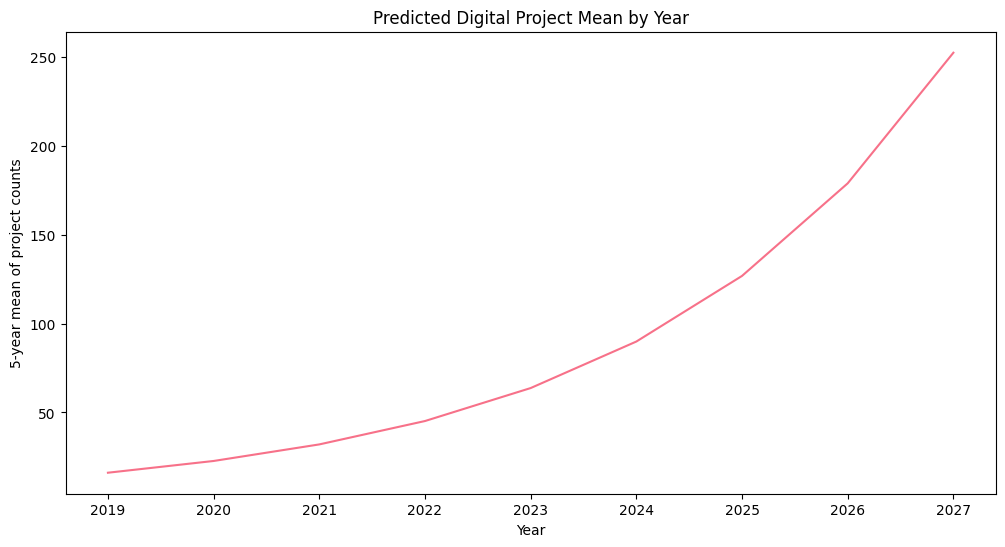

In [24]:
# Set the color palette to 'husl'
sns.set_palette('husl')
fig = plt.figure(figsize=(12, 6))

# Plot the future predictions for Category Digital
sns.lineplot(x=df_future[df_future['Category']=='Digital'].index, y='Predicted', data=df_future[df_future['Category']=='Digital'])

plt.title('Predicted Digital Project Mean by Year')
plt.xlabel('Year')
plt.ylabel('5-year mean of project counts')
plt.savefig('../plots/predicted_digital_project_mean_by_year.png', dpi=300, bbox_inches='tight')
plt.show()